# [NTDS'19] assignment 1: network science
[ntds'19]: https://github.com/mdeff/ntds_2019

[Eda Bayram](https://lts4.epfl.ch/bayram), [EPFL LTS4](https://lts4.epfl.ch) and
[Nikolaos Karalias](https://people.epfl.ch/nikolaos.karalias), [EPFL LTS2](https://lts2.epfl.ch).

## Students

* Team: `<5>`
* Students: `<Hugues Vinzant>` (for the indivudual submission) or `<Alice Bizeul, Gaia Carparelli, Antoine Spahr and Hugues Vinzant>` (for the team submission)

## Rules

Grading:
* The first deadline is for individual submissions. The second deadline is for the team submission.
* All team members will receive the same grade based on the team solution submitted on the second deadline.
* As a fallback, a team can ask for individual grading. In that case, solutions submitted on the first deadline are graded.
* Collaboration between team members is encouraged. No collaboration between teams is allowed.

Submission:
* Textual answers shall be short. Typically one to two sentences.
* Code has to be clean.
* You cannot import any other library than we imported.
  Note that Networkx is imported in the second section and cannot be used in the first.
* When submitting, the notebook is executed and the results are stored. I.e., if you open the notebook again it should show numerical results and plots. We won't be able to execute your notebooks.
* The notebook is re-executed from a blank state before submission. That is to be sure it is reproducible. You can click "Kernel" then "Restart Kernel and Run All Cells" in Jupyter.

## Objective

The purpose of this milestone is to explore a given dataset, represent it by network by constructing different graphs. In the first section, you will analyze the network properties. In the second section, you will explore various network models and find out the network model fitting the ones you construct from the dataset.

## Cora Dataset

The [Cora dataset](https://linqs.soe.ucsc.edu/node/236) consists of scientific publications classified into one of seven research fields. 

* **Citation graph:** the citation network can be constructed from the connections given in the `cora.cites` file.
* **Feature graph:** each publication in the dataset is described by a 0/1-valued word vector indicating the absence/presence of the corresponding word from the dictionary and its research field, given in the `cora.content` file. The dictionary consists of 1433 unique words. A feature graph can be constructed using the Euclidean distance between the feature vector of the publications.

The [`README`](data/cora/README) provides details about the content of [`cora.cites`](data/cora/cora.cites) and [`cora.content`](data/cora/cora.content).

## Section 1: Network Properties

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

%matplotlib inline

### Question 1: Construct a Citation Graph and a Feature Graph

Read the `cora.content` file into a Pandas DataFrame by setting a header for the column names. Check the `README` file.

In [2]:
column_list = ['paper_id'] + [str(i) for i in range(1,1434)] + ['class_label']
pd_content = pd.read_csv('data/cora/cora.content', delimiter='\t', names=column_list) 
pd_content.head()

,paper_id,1,2,3,4,5,6,7,8,9,...,1425,1426,1427,1428,1429,1430,1431,1432,1433,class_label
0,31336,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,Neural_Networks
1,1061127,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,Rule_Learning
2,1106406,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Reinforcement_Learning
3,13195,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Reinforcement_Learning
4,37879,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Probabilistic_Methods


Print out the number of papers contained in each of the reasearch fields.

**Hint:** You can use the `value_counts()` function.

In [3]:
pd_content['class_label'].value_counts()

Neural_Networks           818
Probabilistic_Methods     426
Genetic_Algorithms        418
Theory                    351
Case_Based                298
Reinforcement_Learning    217
Rule_Learning             180
Name: class_label, dtype: int64

Select all papers from a field of your choice and store their feature vectors into a NumPy array.
Check its shape.

In [4]:
my_field = 'Neural_Networks'
features = pd_content[pd_content['class_label'] == my_field].drop(columns=['paper_id','class_label']).to_numpy()
features.shape

(818, 1433)

Let $D$ be the Euclidean distance matrix whose $(i,j)$ entry corresponds to the Euclidean distance between feature vectors $i$ and $j$.
Using the feature vectors of the papers from the field which you have selected, construct $D$ as a Numpy array. 

In [5]:
distance = np.zeros([features.shape[0],features.shape[0]])

for i in range(features.shape[0]):
    distance[i] = np.sqrt(np.sum((features[i,:] - features)**2, axis=1))

In [6]:
distance.shape

(818, 818)

Check the mean pairwise distance $\mathbb{E}[D]$.

In [7]:
# Mean on the upper triangle as the matrix is symetric (we also excluded the diagonal)
mean_distance = distance[np.triu_indices(distance.shape[1],1)].mean()
print('Mean euclidian distance between feature vectors of papers on Neural Networks: {}'.format(mean_distance))

Mean euclidian distance between feature vectors of papers on Neural Networks: 5.696602496555962


Plot an histogram of the euclidean distances.

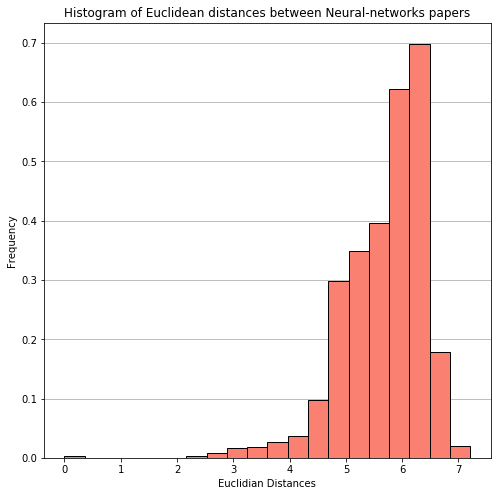

In [8]:
fig,ax = plt.subplots(1,1,figsize=(8, 8))
ax.hist(distance.flatten(), density=True, bins=20, color='salmon', edgecolor='black', linewidth=1);
ax.set_title("Histogram of Euclidean distances between Neural-networks papers")
ax.set_xlabel("Euclidian Distances")
ax.set_ylabel("Frequency")
ax.grid(True, which='major', axis='y')
ax.set_axisbelow(True)
plt.show()

Now create an adjacency matrix for the papers by thresholding the Euclidean distance matrix.
The resulting (unweighted) adjacency matrix should have entries
$$ A_{ij} = \begin{cases} 1, \; \text{if} \; d(i,j)< \mathbb{E}[D], \; i \neq j, \\ 0, \; \text{otherwise.} \end{cases} $$

First, let us choose the mean distance as the threshold.

In [9]:
threshold = mean_distance
A_feature = np.where(distance < threshold, 1, 0)
np.fill_diagonal(A_feature,0)

Now read the `cora.cites` file and construct the citation graph by converting the given citation connections into an adjacency matrix.

In [10]:
cora_cites = np.genfromtxt('data/cora/cora.cites', delimiter='\t')

In [11]:
papers = np.unique(cora_cites)
A_citation = np.zeros([papers.size, papers.size])
for i in range(cora_cites.shape[0]):
    A_citation[np.where(papers==cora_cites[i,1]),np.where(papers==cora_cites[i,0])] = 1
A_citation.shape

(2708, 2708)

Get the adjacency matrix of the citation graph for the field that you chose.
You have to appropriately reduce the adjacency matrix of the citation graph.

In [12]:
# get the paper id from the chosen field
field_id = pd_content[pd_content['class_label'] == my_field]["paper_id"].unique()

# get the index of those paper in the A_citation matrix (similar to index on the vector 'papers')
field_citation_id = np.empty(field_id.shape[0]).astype(int)
for i in range(field_id.shape[0]):
    field_citation_id[i] = np.where(papers == field_id[i])[0]

# get the A_citation matrix only at the index of the paper in the field 
A_citation = A_citation[field_citation_id][:,field_citation_id] 
A_citation.shape

(818, 818)

Check if your adjacency matrix is symmetric. Symmetrize your final adjacency matrix if it's not already symmetric.

In [13]:
# a matrix is symetric if it's the same as it's transpose
print('The citation adjency matrix for papers on Neural Networks is symmetric: {}'.format(np.all(A_citation == A_citation.transpose())))
# symetrize it by taking the maximum between A and A.transposed
A_citation = np.maximum(A_citation, A_citation.transpose())

# To verify if the matrix is symetric
print('After modifiying the matrix, it is now symmetric: {}'.format(np.count_nonzero(A_citation - A_citation.transpose())==0))

The citation adjency matrix for papers on Neural Networks is symmetric: False
After modifiying the matrix, it is now symmetric: True


Check the shape of your adjacency matrix again.

In [14]:
A_citation.shape

(818, 818)

### Question 2: Degree Distribution and Moments

What is the total number of edges in each graph?

In [15]:
num_edges_feature = int(np.sum(A_feature)/2) # only half of the matrix
num_edges_citation = int(np.sum(A_citation)/2)
print(f"Number of edges in the feature graph: {num_edges_feature}")
print(f"Number of edges in the citation graph: {num_edges_citation}")

Number of edges in the feature graph: 136771
Number of edges in the citation graph: 1175


Plot the degree distribution histogram for each of the graphs.

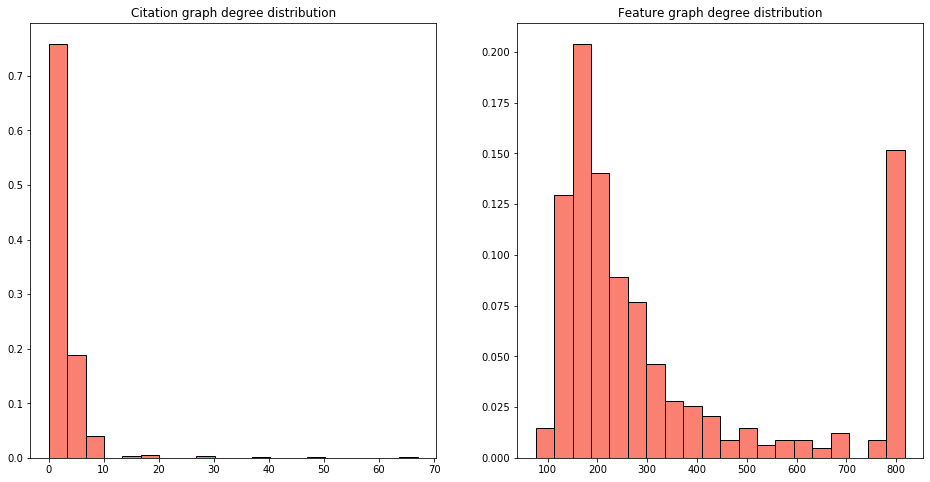

In [16]:
degrees_citation = A_citation.sum(axis=1) # degree = nbr of connections --> sum of ones over columns (axis=1)
degrees_feature = A_feature.sum(axis=1) 

deg_hist_normalization = np.ones(degrees_citation.shape[0]) / degrees_citation.shape[0]

# had to add it because the feature matrix is smaller (onyl neural net papers)
deg_hist_normalization2 = np.ones(degrees_feature.shape[0]) / degrees_feature.shape[0] 

fig, axes = plt.subplots(1, 2, figsize=(16, 8))
axes[0].set_title('Citation graph degree distribution')
axes[0].hist(degrees_citation, weights=deg_hist_normalization, bins=20, color='salmon', edgecolor='black', linewidth=1);
axes[1].set_title('Feature graph degree distribution')
axes[1].hist(degrees_feature, weights=deg_hist_normalization2, bins=20, color='salmon', edgecolor='black', linewidth=1);

Calculate the first and second moments of the degree distribution of each graph.

In [17]:
cit_moment_1 = np.mean(degrees_citation)
cit_moment_2 = np.var(degrees_citation)

feat_moment_1 = np.mean(degrees_feature)
feat_moment_2 = np.var(degrees_feature)

print(f"1st moment of citation graph: {cit_moment_1}")
print(f"2nd moment of citation graph: {cit_moment_2}")
print(f"1st moment of feature graph: {feat_moment_1}")
print(f"2nd moment of feature graph: {feat_moment_2}")

1st moment of citation graph: 2.8728606356968216
2nd moment of citation graph: 15.511952941457784
1st moment of feature graph: 334.4034229828851
2nd moment of feature graph: 55375.54874133943


What information do the moments provide you about the graphs?
Explain the differences in moments between graphs by comparing their degree distributions.

**Your answer here:**
<br> The moments provide an idea of the sparsity of the graphs and the way the data is distributed using numerical values. The first moment is associated with the average value, the second to the variance of the distribution. A large 1st moment would mean a large number of edges per node on average, whereas the 2nd moment give information about the spread of the node's degree around the average value (variance).
<br> Citation degree distribution 1st moment lays around 2.8, and the second one is higher (around 15.5) with a large number of nodes (818). It thus means that there are many nodes with a small degree but there are also larger hubs, the nework is likely to be sparse. The feature degree distribution moments are larger, meaning a rather dense graph. There are many nodes with a degree of above 800 (15%), and since the network contains 818 nodes, it means that many nodes are almost saturated. The high variance shows that the degree distribution is more diffuse around the average value then for the citation graph.
<br>In addition, both distributions are skewed to the right which mean that most of the nodes have a low degree even if some nodes can present higher degrees wich is especially true for the feature degree distribution. 
<br> However using the mean and variance to caratherize skewed distributions is not the best idea. Indeed, those index are less robust than indexes such as the median or quartiles and are easily shifted by small proportions of extremely high or low values as it is the case in our citation distribution for instance.

Select the 20 largest hubs for each of the graphs and remove them. Observe the sparsity pattern of the adjacency matrices of the citation and feature graphs before and after such a reduction.

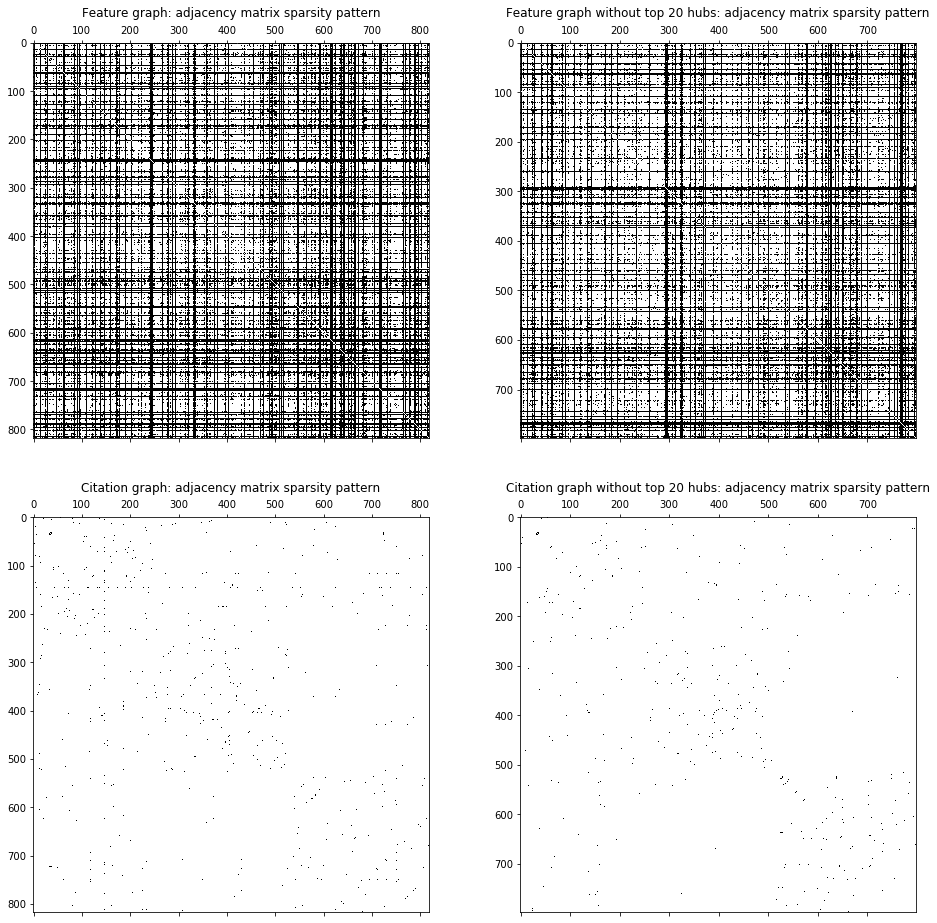

In [18]:
smallest_feat_hub_idx = np.argpartition(degrees_feature, degrees_feature.shape[0]-20)[:-20]
smallest_feat_hub_idx.sort()
reduced_A_feature = A_feature[smallest_feat_hub_idx][:,smallest_feat_hub_idx]

smallest_cit_hub_idx = np.argpartition(degrees_citation, degrees_citation.shape[0]-20)[:-20]
smallest_cit_hub_idx.sort()
reduced_A_citation = A_citation[smallest_cit_hub_idx][:,smallest_cit_hub_idx]

fig, axes = plt.subplots(2, 2, figsize=(16, 16))
axes[0, 0].set_title('Feature graph: adjacency matrix sparsity pattern')
axes[0, 0].spy(A_feature);
axes[0, 1].set_title('Feature graph without top 20 hubs: adjacency matrix sparsity pattern')
axes[0, 1].spy(reduced_A_feature);
axes[1, 0].set_title('Citation graph: adjacency matrix sparsity pattern')
axes[1, 0].spy(A_citation);
axes[1, 1].set_title('Citation graph without top 20 hubs: adjacency matrix sparsity pattern')
axes[1, 1].spy(reduced_A_citation);

Plot the new degree distribution histograms.

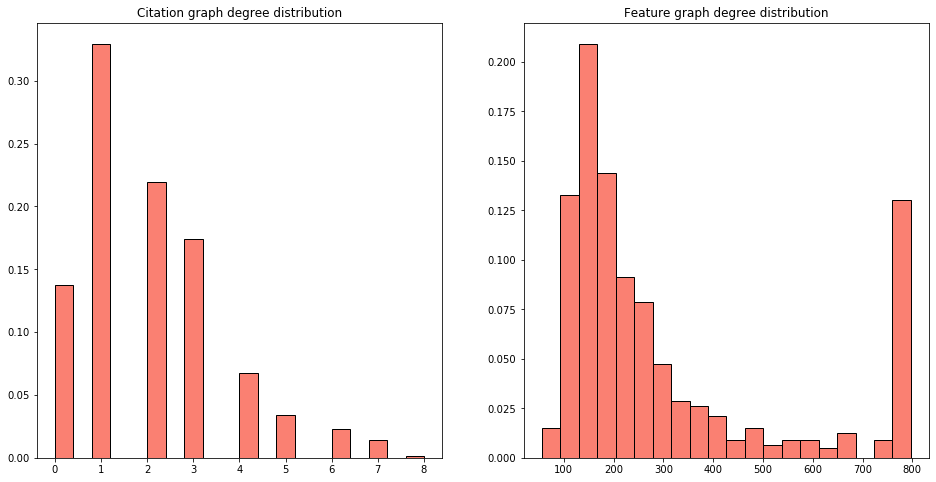

In [19]:
reduced_degrees_feat = reduced_A_feature.sum(axis=1)
reduced_degrees_cit = reduced_A_citation.sum(axis=1)

deg_hist_normalization = np.ones(reduced_degrees_feat.shape[0])/reduced_degrees_feat.shape[0]

deg_hist_normalization2 = np.ones(reduced_degrees_cit.shape[0])/reduced_degrees_cit.shape[0]

fig, axes = plt.subplots(1, 2, figsize=(16, 8))
axes[0].set_title('Citation graph degree distribution')
axes[0].hist(reduced_degrees_cit, weights=deg_hist_normalization2, bins=20, color='salmon', edgecolor='black', linewidth=1);
axes[1].set_title('Feature graph degree distribution')
axes[1].hist(reduced_degrees_feat, weights=deg_hist_normalization, bins=20, color='salmon', edgecolor='black', linewidth=1);

Compute the first and second moments for the new graphs.

In [20]:
reduced_cit_moment_1 = np.mean(reduced_degrees_cit)
reduced_cit_moment_2 = np.var(reduced_degrees_cit)

reduced_feat_moment_1 = np.mean(reduced_degrees_feat)
reduced_feat_moment_2 = np.var(reduced_degrees_feat)

print("Citation graph first moment:", reduced_cit_moment_1)
print("Citation graph second moment:", reduced_cit_moment_2)
print("Feature graph first moment: ", reduced_feat_moment_1)
print("Feature graph second moment: ", reduced_feat_moment_2)

Citation graph first moment: 1.9724310776942355
Citation graph second moment: 2.3801923354752796
Feature graph first moment:  302.30827067669173
Feature graph second moment:  50780.035295004425


Print the number of edges in the reduced graphs.

In [21]:
num_edges_reduced_feature = int(np.sum(reduced_A_feature)/2)
num_edges_reduced_citation = int(np.sum(reduced_A_citation)/2)
print(f"Number of edges in the reduced feature graph: {num_edges_reduced_feature}")
print(f"Number of edges in the reduced citation graph: {num_edges_reduced_citation}")

Number of edges in the reduced feature graph: 120621
Number of edges in the reduced citation graph: 787


Is the effect of removing the hubs the same for both networks? Look at the percentage changes for each moment. Which of the moments is affected the most and in which graph? Explain why.  

**Hint:** Examine the degree distributions.

In [22]:
change_cit_moment_1 = (reduced_cit_moment_1-cit_moment_1)/cit_moment_1
change_cit_moment_2 = (reduced_cit_moment_2-cit_moment_2)/cit_moment_2
change_feat_moment_1 = (reduced_feat_moment_1-feat_moment_1)/feat_moment_1
change_feat_moment_2 = (reduced_feat_moment_2-feat_moment_2)/feat_moment_2

print(f"% change for citation 1st moment: {change_cit_moment_1}")
print(f"% change for citation 2nd moment: {change_cit_moment_2}")
print(f"% change for feature 1st moment: {change_feat_moment_1}")
print(f"% change for feature 2nd moment: {change_feat_moment_2}")

% change for citation 1st moment: -0.3134261184877087
% change for citation 2nd moment: -0.8465575324745928
% change for feature 1st moment: -0.09597734383190214
% change for feature 2nd moment: -0.0829881337664167


We can notice that the fact of removing the 20 largest hubs affects way more the citation degree distribution than the feature degree distribution. The 2nd moment of the citation degree distribution is reduced by almost 85%, this can be due to the fact that there were not so many node with a high degree and they were thus all removed as part of the 20 largest hubs resulting in a much lower variance (less spread distribution).

### Question 3: Pruning, sparsity, paths

By adjusting the threshold of the euclidean distance matrix, prune the feature graph so that its number of edges is roughly close (within a hundred edges) to the number of edges in the citation graph.

In [ ]:
# Should we take the number of edges in reduced citation graph ???
threshold = np.max(distance)
diagonal = distance.shape[0]
threshold_flag = False
epsilon = 0.01*threshold
tolerance = 100

while threshold > 0 and not threshold_flag:
    threshold -= epsilon # steps of 1% of maximum
    n_edge = int((np.count_nonzero(np.where(distance < threshold, 1, 0)) - diagonal)/2)
    
    if (n_edge < num_edges_citation + tolerance) and (n_edge > num_edges_citation - tolerance): # within a hundred edges
    #if abs(num_edges_citation - n_edge) < tolerance:
        threshold_flag = True
        print('Found a threshold')
print(threshold)

A_feature_pruned = np.where(distance < threshold, 1, 0)
np.fill_diagonal(A_feature_pruned, 0)
num_edges_feature_pruned = int(np.count_nonzero(A_feature_pruned)/2)

print(f"Number of edges in the feature graph: {num_edges_feature}")
print(f"Number of edges in the feature graph after pruning: {num_edges_feature_pruned}")
print(f"Number of edges in the citation graph: {num_edges_citation}")

Check your results by comparing the sparsity patterns and total number of edges between the graphs.

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
axes[0].set_title('Citation graph sparsity')
axes[0].spy(A_citation);
axes[1].set_title('Feature graph sparsity')
axes[1].spy(A_feature_pruned);

Let $C_{k}(i,j)$ denote the number of paths of length $k$ from node $i$ to node $j$. 

We define the path matrix $P$, with entries
$ P_{ij} = \displaystyle\sum_{k=0}^{N}C_{k}(i,j). $

Calculate the path matrices for both the citation and the unpruned feature graphs for $N =10$.  

**Hint:** Use [powers of the adjacency matrix](https://en.wikipedia.org/wiki/Adjacency_matrix#Matrix_powers).

In [ ]:
def path_matrix(A, N=10):
    """Compute the path matrix for matrix A for N power """
    power_A = [A]
    for i in range(N-1):
        power_A.append(np.matmul(power_A[-1], A))

    return np.stack(power_A, axis=2).sum(axis=2)

In [ ]:
path_matrix_citation = path_matrix(A_citation)
path_matrix_feature = path_matrix(A_feature)

Check the sparsity pattern for both of path matrices.

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(16, 9))
axes[0].set_title('Citation Path matrix sparsity')
axes[0].spy(path_matrix_citation);
axes[1].set_title('Feature Path matrix sparsity')
axes[1].spy(path_matrix_feature, vmin=0, vmax=1); #scaling the color bar

Now calculate the path matrix of the pruned feature graph for $N=10$. Plot the corresponding sparsity pattern. Is there any difference?

In [ ]:
path_matrix_pruned = path_matrix(A_feature_pruned)

plt.figure(figsize=(12, 6))
plt.title('Feature Path matrix sparsity')
plt.spy(path_matrix_pruned);

**Your answer here:**
<br> many nodes have a path matrix value of zero now, meaning that they are not within the reach of 10 nodes from another node. It makes sense as many edges were removed in the pruning procedure (from 136000 to 1400). 

Describe how you can use the above process of counting paths to determine whether a graph is connected or not. Is the original (unpruned) feature graph connected?

**Your answer here:** 
<br> The graph is connected if all points are within the reach of others. Therefore if the path matrix hasn't any null value, it means that the graph is connected. However, even if the path matrix has some null value it can be connected, this depends on the N-value chosen. For example, if 20 nodes are aligned and linked then we know that all point are reachable. Even though, the number of paths of length 10 between the first and the last node remain 0.

If the graph is connected, how can you guess its diameter using the path matrix?

**Your answer here:**
<br> The diameter corespond to the minimum N for wich the path matrix does not contain any null value.

If any of your graphs is connected, calculate the diameter using that process.

In [ ]:
N=0
diameter = None
d_found = False 
while not d_found:
    N += 1
    P = path_matrix(A_feature, N)
    if np.count_nonzero(P == 0) == 0: # if there are no zero in P
        d_found = True
        diameter = N

print(f"The diameter is: {diameter}")

Check if your guess was correct using [NetworkX](https://networkx.github.io/documentation/stable/reference/algorithms/generated/networkx.algorithms.distance_measures.diameter.html).
Note: usage of NetworkX is only allowed in this part of Section 1.

In [ ]:
import networkx as nx
feature_graph = nx.from_numpy_matrix(A_feature)
print(f"Diameter according to networkx: {nx.diameter(feature_graph)}")

## Section 2: Network Models

In this section, you will analyze the feature and citation graphs you constructed in the previous section in terms of the network model types.
For this purpose, you can use the NetworkX libary imported below.

In [ ]:
import networkx as nx

Let us create NetworkX graph objects from the adjacency matrices computed in the previous section.

In [ ]:
G_citation = nx.from_numpy_matrix(A_citation)
print('Number of nodes: {}, Number of edges: {}'. format(G_citation.number_of_nodes(), G_citation.number_of_edges()))
print('Number of self-loops: {}, Number of connected components: {}'. format(G_citation.number_of_selfloops(), nx.number_connected_components(G_citation)))

In the rest of this assignment, we will consider the pruned feature graph as the feature network.

In [ ]:
G_feature = nx.from_numpy_matrix(A_feature_pruned)
print('Number of nodes: {}, Number of edges: {}'. format(G_feature.number_of_nodes(), G_feature.number_of_edges()))
print('Number of self-loops: {}, Number of connected components: {}'. format(G_feature.number_of_selfloops(), nx.number_connected_components(G_feature)))

### Question 4: Simulation with Erdős–Rényi and Barabási–Albert models

Create an Erdős–Rényi and a Barabási–Albert graph using NetworkX to simulate the citation graph and the feature graph you have. When choosing parameters for the networks, take into account the number of vertices and edges of the original networks.

The number of nodes should exactly match the number of nodes in the original citation and feature graphs.

In [ ]:
assert len(G_citation.nodes()) == len(G_feature.nodes())
n = len(G_citation.nodes())
n

The number of match shall fit the average of the number of edges in the citation and the feature graph.

In [ ]:
m = np.round((G_citation.size() + G_feature.size()) / 2)
m

How do you determine the probability parameter for the Erdős–Rényi graph?

**Your answer here:**
The expected number of edges is given by :  $\langle L \rangle = p\frac{N(N-1)}{2}$ 
<br> Therefore we can get $p$ from the number of edge we want and the number of node we have : $ p = \langle L \rangle\frac{2}{N(N-1)}$ 
<br> The  number of expected edges is given by $m$ in our case.

In [ ]:
p = m*2/(n*(n-1))
G_er = nx.erdos_renyi_graph(n, p)

Check the number of edges in the Erdős–Rényi graph.

In [ ]:
print('My Erdos-Rényi network that simulates the citation graph has {} edges.'.format(G_er.size()))

How do you determine the preferential attachment parameter for Barabási–Albert graphs?

**Your answer here:**
<br>q represent the number of edges to attach from a new node to existing nodes, it can be obtained from the average number of edges per node.

In [ ]:
q = int(m/n)
G_ba = nx.barabasi_albert_graph(n, q)

Check the number of edges in the Barabási–Albert graph.

In [ ]:
print('My Barabási-Albert network that simulates the citation graph has {} edges.'.format(G_ba.size()))

### Question 5: Giant Component

Check the size of the largest connected component in the citation and feature graphs.

In [ ]:
giant_citation = max(nx.connected_component_subgraphs(G_citation), key=len)
print('The giant component of the citation graph has {} nodes and {} edges.'.format(giant_citation.number_of_nodes(), giant_citation.size()))

In [ ]:
giant_feature = max(nx.connected_component_subgraphs(G_feature), key=len)
print('The giant component of the feature graph has {} nodes and {} edges.'.format(giant_feature.number_of_nodes(), giant_feature.size()))

Check the size of the giant components in the generated Erdős–Rényi graph.

In [ ]:
giant_er = max(nx.connected_component_subgraphs(G_er), key=len)
print('The giant component of the Erdos-Rényi network has {} nodes and {} edges.'.format(giant_er.number_of_nodes(), giant_er.size()))

Let us match the number of nodes in the giant component of the feature graph by simulating a new Erdős–Rényi network.
How do you choose the probability parameter this time? 

**Hint:** Recall the expected giant component size from the lectures.

**Your answer here:**
<br> $S = \frac{N_{GC}}{N}$
<br> $S = 1-e^{-\langle k \rangle S}$
<br> $e^{-\langle k \rangle S} =1-S$
<br> $-\langle k \rangle S = ln(1-S)$
<br> $\langle k \rangle = -\frac{1}{S}ln(1-S)$
<br> $p = \frac{\langle k \rangle}{N-1}$

In [ ]:
GC_node = giant_feature.number_of_nodes()
S = GC_node/n
avg_k = -1/S*np.log(1-S)

In [ ]:
p_new = avg_k/(n-1)
G_er_new = nx.erdos_renyi_graph(n, p_new)

Check the size of the new Erdős–Rényi network and its giant component.

In [ ]:
print('My new Erdos Renyi network that simulates the citation graph has {} edges.'.format(G_er_new.size()))
giant_er_new = max(nx.connected_component_subgraphs(G_er_new), key=len)
print('The giant component of the new Erdos-Rényi network has {} nodes and {} edges.'.format(giant_er_new.number_of_nodes(), giant_er_new.size()))

### Question 6: Degree Distributions

Recall the degree distribution of the citation and the feature graph.

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(15, 6))
axes[0].set_title('Citation graph')
citation_degrees =  [deg for (node, deg) in G_citation.degree()]
axes[0].hist(citation_degrees, bins=20, color='salmon', edgecolor='black', linewidth=1);
axes[1].set_title('Feature graph')
feature_degrees = [deg for (node, deg) in G_feature.degree()]
axes[1].hist(feature_degrees, bins=20, color='salmon', edgecolor='black', linewidth=1);

What does the degree distribution tell us about a network? Can you make a prediction on the network model type of the citation and the feature graph by looking at their degree distributions?

**Your answer here:**
<br>The degree distribution tell us the sparsity density of a network.
Yes, both show a power law degree distribution (many nodes with few edges but some big component have a lot of edges). Hence they should fall in the scale-free network category. Therefore the Barabasi-Albert model which is a random scale free model is probably the best match. 

Now, plot the degree distribution historgrams for the simulated networks.

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(20, 8))
axes[0].set_title('Erdos-Rényi network')
er_degrees =  [deg for (node, deg) in G_er.degree()]
axes[0].hist(er_degrees, bins=10, color='salmon', edgecolor='black', linewidth=1)
axes[1].set_title('Barabási-Albert network')
ba_degrees =  [deg for (node, deg) in G_ba.degree()]
axes[1].hist(ba_degrees, bins=10, color='salmon', edgecolor='black', linewidth=1)
axes[2].set_title('new Erdos-Rényi network')
er_new_degrees =  [deg for (node, deg) in G_er_new.degree()]
axes[2].hist(er_new_degrees, bins=10, color='salmon', edgecolor='black', linewidth=1)
plt.show()

In terms of the degree distribution, is there a good match between the citation and feature graphs and the simulated networks?
For the citation graph, choose one of the simulated networks above that match its degree distribution best. Indicate your preference below.

**Your answer here:** 
<br> Barabasi-Albert network is a good match of both degree distributions

You can also simulate a network using the configuration model to match its degree disctribution exactly. Refer to [Configuration model](https://networkx.github.io/documentation/stable/reference/generated/networkx.generators.degree_seq.configuration_model.html#networkx.generators.degree_seq.configuration_model).

Let us create another network to match the degree distribution of the feature graph. 

In [ ]:
G_config = nx.configuration_model(feature_degrees) 
print('Configuration model has {} nodes and {} edges.'.format(G_config.number_of_nodes(), G_config.size()))

Does it mean that we create the same graph with the feature graph by the configuration model? If not, how do you understand that they are not the same?

**Your answer here:** 
<br> No we don't create the same graph, the number of edges, nodes and degree distribution can be the same but the links can be different. For example, in a group of three papers, various configurations are possible using only 2 links.

### Question 7: Clustering Coefficient

Let us check the average clustering coefficient of the original citation and feature graphs. 

In [ ]:
nx.average_clustering(G_citation)

In [ ]:
nx.average_clustering(G_feature)

What does the clustering coefficient tell us about a network? Comment on the values you obtain for the citation and feature graph.

**Your answer here:**
<br> Clustering coefficient is linked to the presence of subgroups (or clusters) in the network. A high clustering coefficient means that a node is very likely to be part of a subgroup. Here we can observe that the clustering coefficient of the citation graph is higher (almost double) than the one of the feature graph, this can highlight the fact that citations are more likely to form subgroups than feature.


Now, let us check the average clustering coefficient for the simulated networks.

In [ ]:
nx.average_clustering(G_er)

In [ ]:
nx.average_clustering(G_ba)

In [ ]:
nx.average_clustering(nx.Graph(G_config))

Comment on the values you obtain for the simulated networks. Is there any good match to the citation or feature graph in terms of clustering coefficient?

**Your answer here:**
<br> No, there is not any match. The clustering coefficients are rather small compared to the ones for feature and citation graphs. Random networks have generally small clustering coefficients because they don't tend to form subgroups as the pairing is random.

Check the other [network model generators](https://networkx.github.io/documentation/networkx-1.10/reference/generators.html) provided by NetworkX. Which one do you predict to have a better match to the citation graph or the feature graph in terms of degree distribution and clustering coefficient at the same time? Justify your answer.

**Your answer here:**
<br> Power law cluster model...

If you find a better fit, create a graph object below for that network model. Print the number of edges and the average clustering coefficient. Plot the histogram of the degree distribution.

In [ ]:
k = m*2/n
p = (nx.average_clustering(G_citation) + nx.average_clustering(G_feature))/2
G_pwc = nx.powerlaw_cluster_graph(n, int(k), p)
 
print('Power law cluster model has {} edges.'.format(G_pwc.size()))
print('Power law cluster model has a clustering coefficient of {}'.format(nx.average_clustering(G_pwc)))
print('Citation model has {} edges.'.format(G_citation.size()))
print('Citation model has a clustering coefficient of {}'.format(nx.average_clustering(G_citation)))
print('Feature model has {} edges.'.format(G_feature.size()))
print('Feature model has a clustering coefficient of {}'.format(nx.average_clustering(G_feature)))

fig, axs = plt.subplots(1, 3, figsize=(15, 5), sharey=True, sharex=True)
axs[0].set_title('PWC graph')
ws_degrees =  [deg for (node, deg) in G_pwc.degree()]
axs[0].hist(ws_degrees, bins=20, color='salmon', edgecolor='black', linewidth=1)
axs[1].set_title('Citation graph')
citation_degrees =  [deg for (node, deg) in G_citation.degree()]
axs[1].hist(citation_degrees, bins=20, color='salmon', edgecolor='black', linewidth=1)
axs[2].set_title('Feature graph')
feature_degree =  [deg for (node, deg) in G_feature.degree()]
axs[2].hist(feature_degree, bins=20, color='salmon', edgecolor='black', linewidth=1)
plt.show()

Comment on the similarities of your match.

**Your answer here:**
<br> Remains a power law, the clustering coefficients are close, the decay is closer to the citation graph...